In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd

In [48]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [50]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [55]:
# Display the first row's columns and data in dictionary format for table Station
first_row_Station = session.query(Station).first()
first_row_Station.__dict__   

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2078e1588d0>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [56]:
# Display the first row's columns and data in dictionary format for table Measurement
first_row_Measurement = session.query(Measurement).first()
first_row_Measurement.__dict__   

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2078df95b38>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [57]:
'''Determine time range of this dataset to be shown on index.html of ClimateApp'''
# Query for date of the latest documented data from "measurement" table
date_latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Query for date of the oldest documented data from "measurement" table
date_earliest = session.query(Measurement.date).order_by(Measurement.date).first()[0]

# Display time range of this dataset
print(f'Time range of this dataset is from {date_earliest} to {date_latest}.')

Time range of this dataset is from 2010-01-01 to 2017-08-23.


In [58]:
# Determine the date that is exactly 1 year apart (inclusive) from "date_latest"
date_latest_list = [int(i) for i in date_latest.split("-")]
date_thold_1yr = dt.date(*date_latest_list) - dt.timedelta(days=365)

# Display one-year threshold date
print(f'One-year threshold date towards "date_latest" is {date_thold_1yr}.')

One-year threshold date towards "date_latest" is 2016-08-23.


In [59]:
# Query date and prcp data for the last 12 months
date_prcp_list = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date>=date_thold_1yr.strftime('%Y-%m-%d')).order_by(Measurement.date).all()


In [60]:
# Retrieve date and prcp data from date_prcp_list
list_date=[i[0] for i in date_prcp_list]
list_prcp=[i[1] for i in date_prcp_list]

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({"Date":list_date,"prcp":list_prcp}).set_index("Date")
# Sort the dataframe by date and drop the rows including null values
df = df.sort_values(by="Date").dropna()
df.head()

,prcp
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


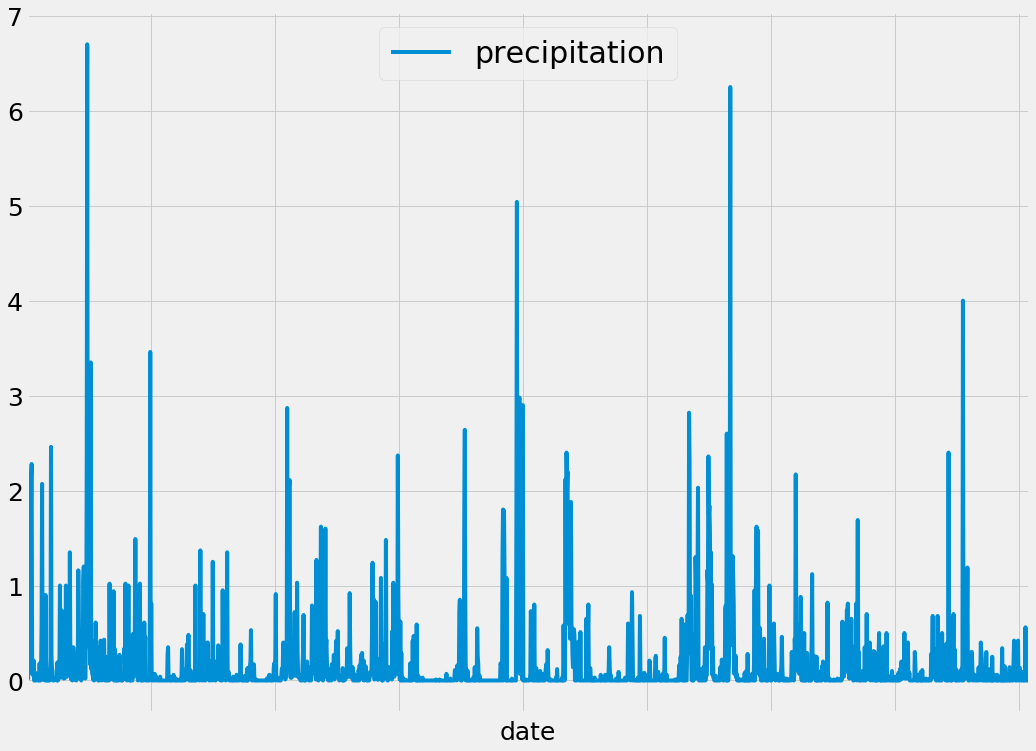

In [61]:

from matplotlib.ticker import NullFormatter

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(df))
ax = df.plot(kind='line',figsize=(16,12))
# Set grid, xlabel and legend
plt.grid(True)
plt.xlabel("date", fontsize= 25)
plt.legend(["precipitation"],loc="upper center", fontsize= 30)
# Remove xtick label
ax.xaxis.set_major_formatter(NullFormatter())
# Set yticks fontsize
plt.yticks(fontsize=25)
# Save plot
plt.savefig('output_images/Precipitation Analysis.png', dpi=300)
plt.show()

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df["prcp"].describe()


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

### Station Analysis

In [63]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station.station).count()


print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(f"The most active stations is {station_count[0][0]}.")
station_count  


The most active stations is USC00519281.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
tem_expl = session.query(*sel).\
                  filter(Measurement.station==station_count[0][0]).all()
tem_expl  

[(54.0, 85.0, 71.66378066378067)]

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
tem_list = session.query(Measurement.tobs).filter(Measurement.station== station_count[0][0]).\
            filter(Measurement.date>= date_thold_1yr.strftime('%Y-%m-%d')).order_by(Measurement.date).all()
tem_list = [i[0] for i in tem_list]

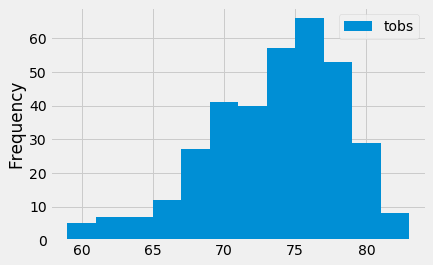

In [67]:
# plot the results as a histogram
plt.hist(tem_list,bins=12)
# Set legend and ylabel
plt.legend(["tobs"])
plt.ylabel("Frequency")
# Set grid
plt.grid(True)
#  Save plot
plt.savefig('output_images/Station Analysis.png')

In [68]:
def stations():
    station_list = session.query(Measurement.station).all()
    station_list = list(set(station_list))
    
    station_list = list(np.ravel(station_list))
    return station_list
stations()

['USC00516128',
 'USC00513117',
 'USC00518838',
 'USC00519523',
 'USC00517948',
 'USC00511918',
 'USC00519397',
 'USC00519281',
 'USC00514830']

### Temperature Analysis

In [69]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [70]:
# For our trip We set start_date and end_start
start_date_2019 = '2019-04-16'
end_date_2019 = "2019-04-21"

# We will use 2017 data
start_date_2017 = "2017-04-16"
end_date_2017 = "2017-04-21"

# Calculate TMIN, TAVE, and TMAX for the trip time in 2017
calc_temps(start_date_2017, end_date_2017)

[(67.0, 72.375, 83.0)]

In [71]:
TMIN = calc_temps(start_date_2017, end_date_2017)[0][0]
TAVE = calc_temps(start_date_2017, end_date_2017)[0][1]
TMAX = calc_temps(start_date_2017, end_date_2017)[0][2]
print(f"Temp Min: {TMIN}, Temp Avg: {TAVE},  Temp max: {TMAX}")

Temp Min: 67.0, Temp Avg: 72.375,  Temp max: 83.0


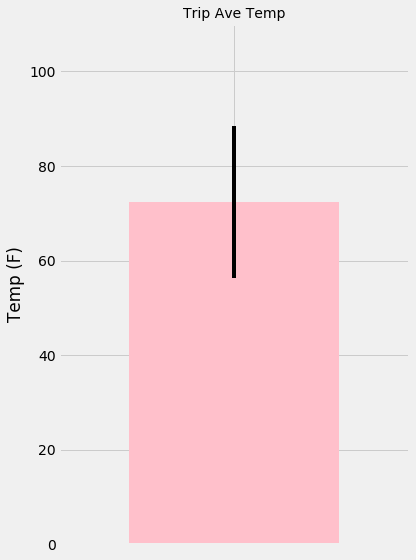

In [72]:
# Plot figure for Trip Ave Temp
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(6,8))
plt.bar(1, TAVE,color = 'pink', yerr = TMAX-TMIN, align='center',tick_label="", width=1.2) 

# Set x_axis and y_axis scale limitation
plt.ylim(0,110)
plt.xlim(0,2)

# Use "Trip Avg Temp" as Title
plt.title(f"Trip Ave Temp", fontsize=14)
# Set ylabel
plt.ylabel("Temp (F)")
plt.tight_layout()
# Save plot
plt.savefig('output_images/Trip Ave Temp.png')

plt.show()

### Total Rainfall Analysis

In [73]:
import pprint
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel= [Station.station,Station.name,Station.elevation, Station.longitude, Station.elevation,
                  func.sum(Measurement.prcp)]
rainfall_info = session.query(*sel).filter(Measurement.station == Station.station)\
                .filter(Measurement.date >= start_date_2017)\
                .filter(Measurement.date <= end_date_2017).group_by(Station.station)\
                .order_by(func.sum(Measurement.prcp).desc()).all()
                           
   
                  
pprint.saferepr(rainfall_info)    

"[('USC00519281', 'WAIHEE 837.5, HI US', 32.9, -157.84888999999998, 32.9, 5.35), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 152.4, -157.8025, 152.4, 4.37), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, -157.71139, 19.5, 3.1599999999999997), ('USC00513117', 'KANEOHE 838.1, HI US', 14.6, -157.8015, 14.6, 2.4899999999999998), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, -157.8374, 7.0, 1.17), ('USC00519397', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 3.0, 0.32), ('USC00517948', 'PEARL CITY, HI US', 11.9, -157.9751, 11.9, 0.0)]"

## Optional Challenge Assignment

### Daily Normals

In [74]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, 
    tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [75]:
# Set the start and end date of the trip
start_date_2019 = '2019-04-16'
end_date_2019 = "2019-04-21"
# Convert start_date to int list
start_date_2019_list = [int(i) for i in start_date_2019.split('-')]
# Calculate the whole trip during days and record all the date of the trip
Trip_During = 1
Trip_date_list = [start_date_2019]

query_date = dt.date(*start_date_2019_list) 
while query_date != end_date_2019:
    query_date = dt.date(*start_date_2019_list) + dt.timedelta(days = Trip_During)
    # Convert datetime object to a String of date
    query_date = query_date.strftime('%Y-%m-%d')
    Trip_date_list.append(query_date)
    Trip_During = Trip_During +1
    


In [39]:
# Display all the date the trip including
print(f"My trip has {len(Trip_date_list)} days.")
pprint.saferepr(Trip_date_list) 


My trip has 6 days.


"['2019-04-16', '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21']"

In [40]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(i[-5:])[0] for i in Trip_date_list]
normals

[(62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0)]

In [41]:
# Add trip_dates in the list
normals_1 =[list(i) for i in normals]
for i in range(len(Trip_date_list)):
    normals_1[i].append(Trip_date_list[i])
normals_1

[[62.0, 71.55357142857143, 81.0, '2019-04-16'],
 [65.0, 71.93103448275862, 77.0, '2019-04-17'],
 [67.0, 72.49152542372882, 77.0, '2019-04-18'],
 [65.0, 72.42105263157895, 83.0, '2019-04-19'],
 [64.0, 72.73684210526316, 80.0, '2019-04-20'],
 [66.0, 72.32142857142857, 78.0, '2019-04-21']]

In [42]:
# Load the previous query results into a Pandas DataFrame and set date as index
df2= pd.DataFrame(np.array(normals_1),columns=["tmin", "tavg", "tmax","date"]).set_index("date")
df2


,tmin,tavg,tmax
date,,,
2019-04-16,62.0,71.55357142857143,81.0
2019-04-17,65.0,71.93103448275862,77.0
2019-04-18,67.0,72.49152542372882,77.0
2019-04-19,65.0,72.42105263157895,83.0
2019-04-20,64.0,72.73684210526316,80.0
2019-04-21,66.0,72.32142857142857,78.0


In [43]:
# Convert value from str to float for columns 'tmin','tavg','tmax'
df2['tmin']=df2['tmin'].apply(lambda x: pd.to_numeric(x))
df2['tavg']=df2['tavg'].apply(lambda x: pd.to_numeric(x))
df2['tmax']=df2['tmax'].apply(lambda x: pd.to_numeric(x))

In [44]:
# Check the change
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 2019-04-16 to 2019-04-21
Data columns (total 3 columns):
tmin    6 non-null float64
tavg    6 non-null float64
tmax    6 non-null float64
dtypes: float64(3)
memory usage: 192.0+ bytes


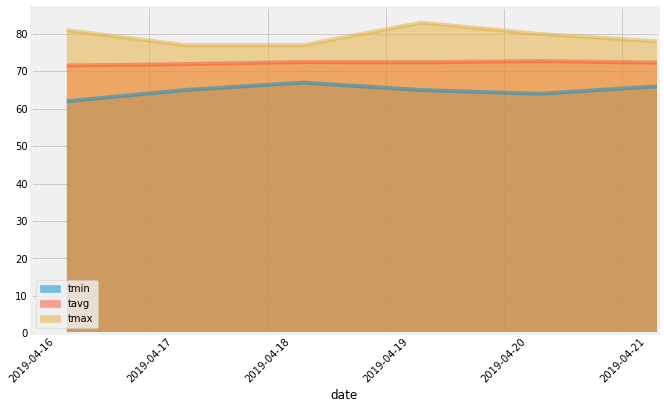

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
x_axis=[(i-0.3) for i in range(len(df2))]
df2.plot.area(stacked=False, figsize=(10,6),alpha=0.5)
plt.xticks(x_axis, df2.index, rotation=45)
plt.xlabel("date")

# Save plot
plt.savefig('output_images/Daily Temp Normals.png')